In [60]:
import csv
import json
import os
import re

import numpy as np
import matplotlib.pyplot as plt
import scqubits as scq
import skrf as rf


# 1. Vector Fitting

In [61]:
admittance_directory = r'C:\Users\mattm\OneDrive\Desktop\Research\Projects\Triangle Lattice\Microwave Office\8Q capacitive\device design\8Q_triangle_lattice_v1\admittance synthesis\admittance_traces'

number_of_ports = 1

y_filepath = os.path.join(admittance_directory, 'Q1_y.txt')

frequencies = []
admittances = []

# regex to find matrix element index
matrix_element_regex = re.compile(r"Im\(Y\((?P<i>\d),(?P<j>\d).*")

# determine number of data points
counter = 0
with open(y_filepath, newline='') as csvfile:
    reader = csv.reader(csvfile, delimiter='\t', quotechar='|')
    for row in reader:
        counter += 1
        
y_matrix = np.empty((counter-1, number_of_ports, number_of_ports), dtype='complex')

with open(y_filepath, newline='') as csvfile:
    reader = csv.reader(csvfile, delimiter='\t', quotechar='|')
    
    
    i = 0
    for row in reader:
        if i == 0:
            headers = row[1:]
            matrix_element_order = []
            
            for header in headers:
            
                match = matrix_element_regex.search(header)
                groupdict = match.groupdict()
                matrix_element_order.append((int(groupdict['i'])-1, int(groupdict['j'])-1))
            
        elif i > 0:
            frequency = float(row[0])
            frequencies.append(frequency)
            
            for j, value in enumerate(row[1:]):
                
                index_1, index_2 = matrix_element_order[j]
                
                y_matrix[i-1, index_1, index_2] = 1j*float(value)
                
                if index_1 != index_2:
                    y_matrix[i-1, index_2, index_1] = 1j*float(value)
            
        i += 1
        
frequencies = np.array(frequencies)


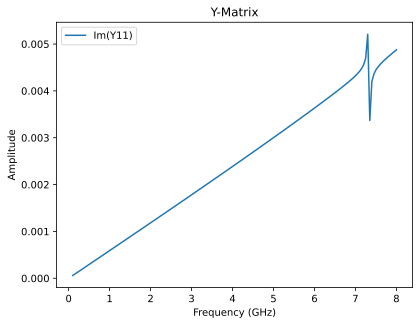

In [62]:
# plot admittances

for i in range(number_of_ports):
    for j in range(number_of_ports):
        
        if i == 2 and j == 2:
            continue
        
        if i <= j:
            plt.plot(frequencies, np.imag(y_matrix[:, i, j]), label=f'Im(Y{i+1}{j+1})')

plt.xlabel('Frequency (GHz)')
plt.ylabel('Amplitude')

plt.legend()

plt.title('Y-Matrix')

plt.show()

In [63]:
frequencies_Hz = frequencies * 1e9
network = rf.Network(frequency=frequencies_Hz, y=y_matrix)
vector_fit = rf.VectorFitting(network)

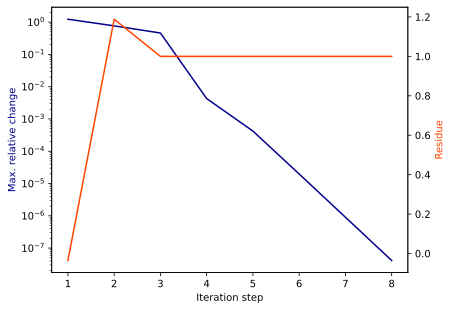

RMS error y11 = 3.1690228461467555e-05


In [64]:
vector_fit.vector_fit(n_poles_real=0, n_poles_cmplx=1, parameter_type='y', fit_constant=False, fit_proportional=True)
vector_fit.plot_convergence()
plt.show()

for i in range(number_of_ports):
    for j in range(number_of_ports):
        if i <= j:
            print(f'RMS error y{i+1}{j+1} = {vector_fit.get_rms_error(i, j, parameter_type="y")}')


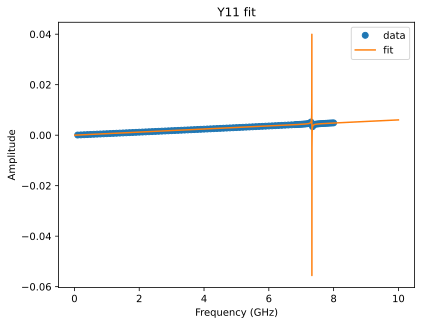

In [65]:
# plot all fits

fit_model_frequencies = np.linspace(0.01e9, 10e9, 10000)

for i in range(number_of_ports):
    for j in range(number_of_ports):
        
        if i <= j:
            model_yij = vector_fit.get_model_response(i, j, fit_model_frequencies)


            # Yij
            plt.plot(frequencies, np.imag(y_matrix[:,i,j]), linestyle='', marker='o', label='data')
            plt.plot(fit_model_frequencies/1e9, np.imag(model_yij), label='fit')

            plt.xlabel('Frequency (GHz)')
            plt.ylabel('Amplitude')

            plt.legend()

            plt.title(f'Y{i+1}{j+1} fit')
            plt.show()


In [66]:
# put residues into NxN matrices where N is number of ports
residues = vector_fit.residues
number_of_poles = len(vector_fit.poles)

print(residues.shape)
print(number_of_poles)

# complex pole
if number_of_poles > 1:
    residues_reshaped = np.real(np.reshape(residues, (number_of_ports, number_of_ports, number_of_poles)))
else:
    residues_reshaped = np.real(np.reshape(residues, (number_of_ports, number_of_ports)))
    
print()
print('Residue from complex pole 1')
print(residues_reshaped)

(1, 1)
1

Residue from complex pole 1
[[140056.49847118]]


In [67]:
# perform SVD on each NxN residue matrix

# complex pole

# len is number of poles, elements are M NxN rank 1 matrices where M is the rank of the original NxN residue matrix 
r_vectors = []
ranks = []

for k in range(number_of_poles):
    
    if number_of_poles > 1:
        residue = residues_reshaped[:,:,k]
    else:
        residue = residues_reshaped
    
    rank = np.linalg.matrix_rank(residue)
    ranks.append(rank)

    U, S, V = np.linalg.svd(residue)
    
    print(S)
    
    r_vectors_k = np.zeros((rank, number_of_ports))
        
    for rank_index in range(rank):
        r_vectors_k[rank_index, :] = np.sqrt(2*S[rank_index])*U[:,rank_index]
        
    r_vectors.append(r_vectors_k)
        
        
max_rank = np.max(ranks)
print(ranks)
for r_vector_k in r_vectors:
    print(r_vector_k.shape)

[140056.49847118]
[1]
(1, 1)


In [68]:
# define circuit parameters for complex pole

# total capacitances C_k
C_k = 20e-15 # F
C_ks = np.array([C_k]*number_of_poles*max_rank) 
C_ks = np.reshape(C_ks, (number_of_poles, max_rank))


# pole frequency omega_k
omega_ks = np.imag(vector_fit.poles) # Hz * 2pi

frequency_ks = omega_ks/2/np.pi # Hz

# print(f'pole 2 frequency: {frequency_2} GHz')
print(f'\nPole frequencies: {frequency_ks/1e9} GHz')


# pole inductance L_k
print(f'\nMode inductances (nH)')
L_ks = np.zeros((number_of_poles, max_rank))
for k in range(number_of_poles):
    L_ks[k,:] = 1/(omega_ks[k]**2*C_ks[k,:]) # H

    print(f'\tpole {k}: {L_ks[k,:] * 1e9}')


# Coupling capacitances [C_ki]_j = sqrt(C_k)/(omega_k) [r_ki]_j

C_coupling_ks = np.zeros((number_of_poles, max_rank, number_of_ports))

print('\nCoupling capacitances (fF)')
for k in range(number_of_poles):
    for rank_index in range(max_rank):
        C_coupling_ks[k, rank_index, :] = np.sqrt(C_ks[k, rank_index])/omega_ks[k] * r_vectors[k][rank_index, :]


        print(f'\tpole {k}, rank index {rank_index}: {C_coupling_ks[k, rank_index, :] * 1e15}')


# capacitance to ground C_kig = C_k - sum_j [C_ki]_j
C_g_ks = np.zeros((number_of_poles, max_rank))

print('\nPole capacitance to ground (fF)')
for k in range(number_of_poles):
    for rank_index in range(max_rank):
        C_g_ks[k, rank_index] = C_ks[k, rank_index] - np.sum(C_coupling_ks[k, rank_index, :])
        
        print(f'\tpole {k}, rank index {rank_index}: {C_g_ks[k, rank_index] * 1e15} fF')


# fit proportional capacitance C_n
C_n = np.reshape(vector_fit.proportional_coeff, (number_of_ports, number_of_ports)) # F
print(f'\nproportional coefficients (fF): \n{C_n * 1e-15}')


Pole frequencies: [7.32903452] GHz

Mode inductances (nH)
	pole 0: [23.57853041]

Coupling capacitances (fF)
	pole 0, rank index 0: [1.6253803]

Pole capacitance to ground (fF)
	pole 0, rank index 0: 18.374619697994262 fF

proportional coefficients (fF): 
[[9.64012841e-29]]


In [69]:
# define capacitance matrix

first_term = 0
second_term = 0
for k in range(number_of_poles):
    
    omega = omega_ks[k]
        
    if omega == 0:
        continue
    
    for rank_index in range(max_rank):
        
        r_vector = r_vectors[k][rank_index, :]
        
        first_term += np.outer(r_vector, r_vector)/(omega**2)
        
        second_term += - np.sqrt(C_ks[k, rank_index])/omega * np.diag(r_vector)


cap_matrix = C_n + first_term + second_term

cap_matrix_fF = cap_matrix * 1e15

print('Capacitance Matrix (fF)')
print(cap_matrix_fF)

# analyze capacitance matrix to get capacitances to ground

capacitance_to_grounds = np.sum(cap_matrix, -1)
print(f'\nNode capacitance to grounds: {capacitance_to_grounds * 1e15} fF')

Capacitance Matrix (fF)
[[94.90799686]]

Node capacitance to grounds: [94.90799686] fF


# 2. SCQubits

In [71]:
circuit_parameters = {}

for k in range(number_of_poles):
    for rank_index in range(max_rank):
        circuit_parameters[f'pole_inductance_{k*number_of_poles + rank_index}'] = L_ks[k, rank_index] * 1e9 # nH
        circuit_parameters[f'pole_capacitance_ground_{k*number_of_poles + rank_index}'] = C_g_ks[k, rank_index] * 1e15 # fF
        
        for i in range(number_of_ports):
            circuit_parameters[f'coupling_capacitance_{k*number_of_poles + rank_index}_{i}'] = C_coupling_ks[k, rank_index, i] * 1e15 # fF

for i in range(number_of_ports):
    
    circuit_parameters[f'node_capacitance_ground_{i}'] = capacitance_to_grounds[i] * 1e15 # fF
    
    for j in range(number_of_ports):
        
        if i != j:
            circuit_parameters[f'internode_capacitance_{i}{j}'] = -cap_matrix_fF[i, j] # fF
            
            
for key, value in circuit_parameters.items():
    print(f'{key}: {value}')

pole_inductance_0: 23.57853040546298
pole_capacitance_ground_0: 18.374619697994262
coupling_capacitance_0_0: 1.6253803020057405
node_capacitance_ground_0: 94.90799685596782


In [50]:
# C_q1 tot
C_tot_q1 = circuit_parameters['node_capacitance_ground_0'] + np.sum([circuit_parameters[f'coupling_capacitance_0_{i}'] for i in range(1)])
# C_tot_q1 = circuit_parameters['node_capacitance_ground_0']
print(f'C_tot_q1: {C_tot_q1}')

C_tot_q1: 96.66457287090299


### 2.2 Create circuit yaml

In [75]:
def create_circuit_yaml(circuit_parameters, num_poles, num_ranks, num_ports, junction_EJ, parasitic_capacitance, loop_phase=0):
    
    yaml_str = 'branches:'
    
    total_num_poles = num_poles * num_ranks
    num_nodes = 1 + num_ports + total_num_poles
    
    for i in range(num_nodes):
        for j in range(i+1, num_nodes):
            # add capacitances
            capacitance = None
    
            if i == 0:
                # ground to everything (capacitances)
                if j in range(1, 1 + num_ports):
                    capacitance = circuit_parameters[f'node_capacitance_ground_{j - 1}']
                elif j in range(1 + num_ports, 1 + num_ports + total_num_poles):
                    capacitance = circuit_parameters[f'pole_capacitance_ground_{j - 1 - total_num_poles}']
                    
                    inductance = circuit_parameters[f'pole_inductance_{j - 1 - total_num_poles}']
                    yaml_str += f'\n- ["L", {i}, {j}, {inductance}nH]'
                    
            elif i in range(1, 1 + num_ports):
                # q to everything (capacitance)
                if j in range(1, 1 + num_ports):
                    capacitance = circuit_parameters[f'internode_capacitance_{i - 1}{j - 1}']
                elif j in range(1 + num_ports, 1 + num_ports + total_num_poles):
                    capacitance = circuit_parameters[f'coupling_capacitance_{j - 1 - total_num_poles}_{i - 1}']
            
            if not capacitance is None:
                yaml_str += f'\n- ["C", {i}, {j}, {capacitance}fF]'
                
    # add junction
    yaml_str += f'\n- ["JJ", 0, 1, EJ_q = {junction_EJ}, {parasitic_capacitance}fF]'
    
    return yaml_str
                    

In [248]:
# define junction parameters

h = 6.626e-34
hbar = h/(2*np.pi)
e = 1.6e-19 # Coulombs

Phi0 = h/(2*e)

# qubit 
EC = e**2/(2*C_tot_q1)/h
EC_MHz = EC*1e9

EJ_q = 20 # GHz
EJ_q_J = EJ_q * h # J

L_J = (Phi0/(2*np.pi))**2/EJ_q_J # nH

C_parasitic_q = 20 # fF


print(f'Qubit 1 junction inductance: {L_J} nH')

frequency_estimate = 1/np.sqrt(L_J * 129.5)/(2*np.pi)*1e6
frequency_estimate = (np.sqrt(8*EC*EJ_q) - EC)*1e6

print(f'frequency estimate: {frequency_estimate} MHz')



Qubit 1 junction inductance: 8.195241245289674 nH
frequency estimate: 5654.448375057234 MHz


In [249]:
EC_MHz

199.84404051090817

In [250]:
num_poles = 1
num_ranks = 1
num_ports = 1

circuit_yaml = create_circuit_yaml(circuit_parameters, num_poles, num_ranks, num_ports, EJ_q, C_parasitic_q)

print(circuit_yaml)

branches:
- ["C", 0, 1, 94.90799685596782fF]
- ["L", 0, 2, 23.57853040546298nH]
- ["C", 0, 2, 18.374619697994262fF]
- ["C", 1, 2, 1.6253803020057405fF]
- ["JJ", 0, 1, EJ_q = 20, 20fF]


### 2.3 Analyze Circuit

In [251]:
def create_circuit(circuit_parameters, num_poles, num_ranks, num_ports, junction_EJs, parasitic_capacitances):   
    circuit_yaml = create_circuit_yaml(circuit_parameters, num_poles, num_ranks, num_ports, junction_EJs, parasitic_capacitances)
    circuit = scq.Circuit(circuit_yaml, from_file=False, ext_basis='harmonic', basis_completion='canonical')

    
    
    circuit.configure(np.identity(2))
#     circuit.variable_transformation()


#     print(circuit.cutoff_names)

    circuit.cutoff_n_1 = 20
    circuit.cutoff_ext_2 = 20
    
    return circuit

In [252]:
circuit = create_circuit(circuit_parameters, num_poles, num_ranks, num_ports, EJ_q, C_parasitic_q)

In [253]:
evals = circuit.eigenvals(4)
f_01 = evals[1] - evals[0]
f_12 = evals[3] - evals[1]
print(f_01)
print(f_12)
print(f_01 - f_12)

4.982477254691004
4.8028053222786165
0.17967193241238721


Spectral data:   0%|          | 0/11 [00:00<?, ?it/s]

(<Figure size 640x480 with 1 Axes>,
 <Axes: xlabel='EJ_q', ylabel='energy [GHz]'>)

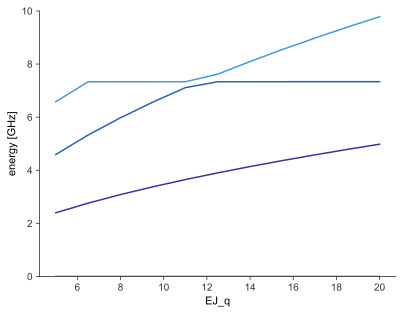

In [254]:
# plot eigenvals vs sweeping EJ_q

EJs = np.linspace(5, 20, 11)

circuit.plot_evals_vs_paramvals('EJ_q', EJs, evals_count=4, subtract_ground=True, ylim=(0, 10))

### 2.4 Anharmonicity vs $E_J$

In [255]:
def get_anharmonicity_vs_EJ(EJs, circuit_parameters, num_poles, num_ranks, num_ports, parasitic_capacitance):

    num_eigenvals = 3
    frequencies = np.zeros((num_eigenvals, len(EJs)))
    
    for i in range(len(EJs)):
        EJ = EJs[i]
    
        circuit = create_circuit(circuit_parameters, num_poles, num_ranks, num_ports, EJ, parasitic_capacitance)

        # get the first four eigenfrequencies
        evals = circuit.eigenvals(num_eigenvals+1)
        for j in range(num_eigenvals):
            frequencies[j, i] = evals[j+1] - evals[0]

    return frequencies

In [263]:
EJs = np.linspace(12, 20, 11)

frequencies = get_anharmonicity_vs_EJ(EJs, circuit_parameters, num_poles, num_ranks, num_ports, C_parasitic_q)

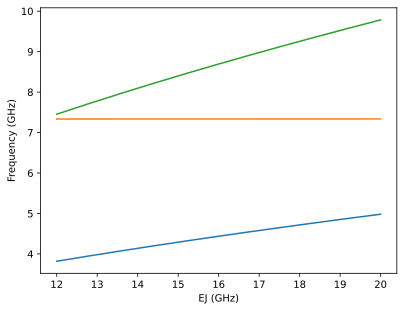

In [264]:
for i in range(frequencies.shape[0]):
    plt.plot(EJs, frequencies[i,:])
    
plt.xlabel('EJ (GHz)')
plt.ylabel('Frequency (GHz)')
plt.show()

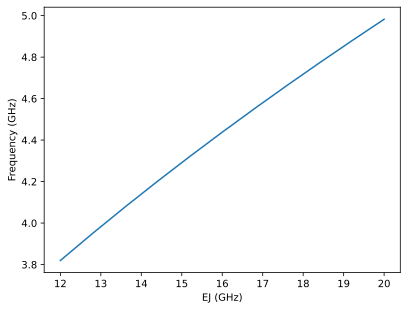

In [265]:
f_01 = frequencies[0,:]

plt.plot(EJs, f_01)
    
plt.xlabel('EJ (GHz)')
plt.ylabel('Frequency (GHz)')
plt.show()

In [266]:
anharmonicities = np.zeros(frequencies.shape[1])

resonator_frequency = frequency_ks[0]/1e9
print(f'resonator: {resonator_frequency} GHz')
atol = 0.050 # GHz

for i in range(len(anharmonicities)):
    if abs(resonator_frequency - frequencies[1,i]) < atol:
        anharmonicities[i] = 2*frequencies[0,i] - frequencies[2,i]
    else:
        anharmonicities[i] = 2*frequencies[0,i] - frequencies[1,i]        

resonator: 7.329034520803124 GHz


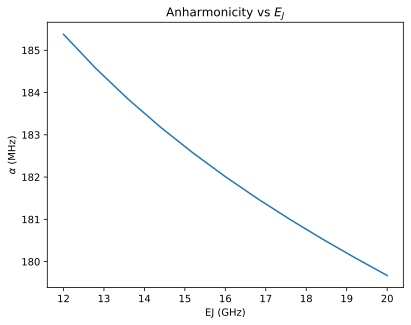

In [267]:
plt.plot(EJs, anharmonicities*1e3)
    
plt.xlabel('EJ (GHz)')
plt.ylabel(r'$\alpha$ (MHz)')

plt.title('Anharmonicity vs $E_J$')
plt.show()

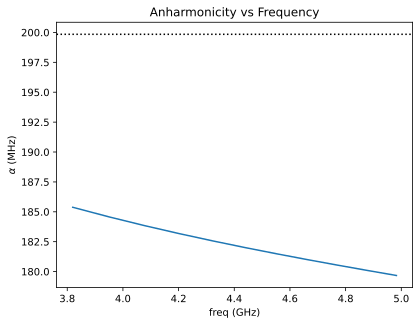

In [268]:
plt.plot(f_01, anharmonicities*1e3)

plt.axhline(EC_MHz, color='black', linestyle=':', label='$E_C$')
    
plt.xlabel('freq (GHz)')
plt.ylabel(r'$\alpha$ (MHz)')
plt.title('Anharmonicity vs Frequency')
plt.show()

1.3241666124252775e-40

### 3. SCQubits Transmon

In [186]:
EC_GHz = EC_MHz * 1e-3

print(f'E_C: {EC_GHz} GHz')
print(f'E_J: {EJ_q} GHz')

E_C: 0.19984404051090818 GHz
E_J: 20 GHz


In [233]:
print(EC*0.8)

1.5987523240872655e-07


In [196]:
transmon = scq.Transmon(EJ=EJ_q,
                        EC=EC_GHz,
                        ng=0,
                        ncut=31)

evals = transmon.eigenvals(4)

In [200]:
f_01 = (evals[1] - evals[0])
f_12 = (evals[2] - evals[1])

print(f_01)
print(f_12)
print(f_01 - f_12)

5.446986531045814
5.228067555975878
0.2189189750699363


In [201]:
100*100/(2000)

5.0

In [214]:
qubit_frequency = f_01
resonator_frequency = 7.3 # GHz
qubit_resonator_coupling = 0.1 # GHz
qubit_2_frequency = f_01 + f_12

# basis: 10, 01 ([qubit, resonator])
one_particle_Ham = np.array([[qubit_frequency, qubit_resonator_coupling],
                             [qubit_resonator_coupling, resonator_frequency]])

# basis: 20, 11, 02 ([qubit, resonator])
two_particle_Ham = np.array([[qubit_2_frequency, np.sqrt(2)*qubit_resonator_coupling, 0],
                             [np.sqrt(2)*qubit_resonator_coupling, qubit_frequency + resonator_frequency, np.sqrt(2)*qubit_resonator_coupling],
                             [0, np.sqrt(2)*qubit_resonator_coupling, 2*resonator_frequency]])

In [215]:
one_particle_frequencies = np.linalg.eigvals(one_particle_Ham)
one_particle_frequencies

array([5.44160554, 7.30538099])

In [216]:
two_particle_frequencies = np.linalg.eigvals(two_particle_Ham)
two_particle_frequencies

array([10.66542241, 12.74585796, 14.61076025])

In [217]:
dressed_anharmonicity = (2*one_particle_frequencies[0] - two_particle_frequencies[0])
dressed_anharmonicity

0.2177886770309403

In [220]:
num_eigenvals = 3
EJ_s = np.linspace(10, 30, 11)
transmon_frequencies = np.zeros((num_eigenvals, len(EJ_s)))


for i in range(len(EJ_s)):
    EJ = EJ_s[i]
    
    transmon.EJ = EJ

    evals = transmon.eigenvals(num_eigenvals+1)
    
    for j in range(num_eigenvals):
        transmon_frequencies[j,i] = evals[j] - evals[0]
        
        

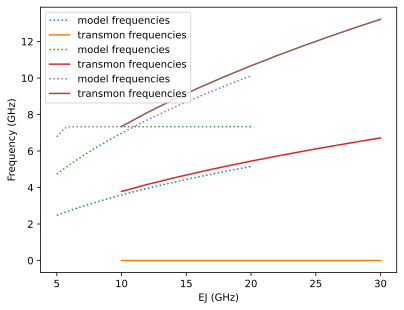

In [225]:
for i in range(transmon_frequencies.shape[0]):
    plt.plot(EJs, frequencies[i,:], linestyle=':', label='model frequencies')
    plt.plot(EJ_s, transmon_frequencies[i,:], label='transmon frequencies')
    
plt.legend()
plt.xlabel('EJ (GHz)')
plt.ylabel('Frequency (GHz)')
plt.show()

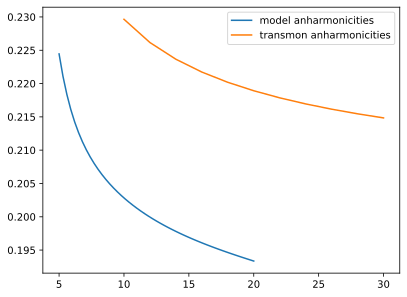

In [231]:
transmon_anharmonicities = 2*transmon_frequencies[1,:] - transmon_frequencies[2,:]

plt.plot(EJs, anharmonicities, label='model anharmonicities')
plt.plot(EJ_s, transmon_anharmonicities, label='transmon anharmonicities')
plt.legend()